# Modélisation : 

1. Preparation des données :
   - Séparation train test split
   - StandardScaler
2. Première modélisation  :
    - DummyRegressor, LinearRegression, RandomForest, etc..
    - Mesure des resultats : RMSE, MSE, MAE, etc.
    - graphique prediction Vs valeur réelle
    - Résultats
3. Sélection de modèle(s) sérieux pour la modélisation final
    - Mesure et comparer resultats

In [39]:
from sklearn.preprocessing import StandardScaler
# ^^^ pyforest auto-imports - don't write above this line
import numpy as np
import pandas as pd 
import os
from termcolor import colored


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor

import shap

import lime
import lime.lime_tabular


import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "D:/Etude_Data_science/Kaggle_competition/17_Predicting_the_Beats-per-Minute_of_Songs/dataset//"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv", index_col=0)
df = train.copy()

In [3]:
print(df.shape)
df.head()

(524164, 11)


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


# 1. Preparation des données :

#### Séparation en train et test set 

In [4]:
X,y = df.drop(["id","BeatsPerMinute"],axis=1), df["BeatsPerMinute"]
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)

In [5]:
var_cont = X.columns.tolist()

#### Standardisation 

In [6]:
std = StandardScaler()
#Fit uniquement sur le train
std.fit(X_train[var_cont])

# Transform train et test avec les mêmes paramètres
X_train[var_cont] = std.transform(X_train[var_cont])
X_test[var_cont]  = std.transform(X_test[var_cont])
X[var_cont] = std.transform(X[var_cont])  

In [14]:
y

0         147.53020
1         136.15963
2          55.31989
3         147.91212
4          89.58511
            ...    
524159    117.83118
524160     89.02681
524161     90.75885
524162    140.63235
524163     77.45960
Name: BeatsPerMinute, Length: 524164, dtype: float64

In [7]:
print("X train :", X_train.shape)
print("X test :", X_test.shape)
print("y train :", y_train.shape)
print("y test :", y_test.shape)
print()
print("X :", X.shape)
print("y :", y.shape)

X train : (393123, 9)
X test : (131041, 9)
y train : (393123,)
y test : (131041,)

X : (524164, 9)
y : (524164,)


# 2. Première modélisation  :
### 2.1 DummyRegressor, LinearRegression, etc.


In [8]:
def evaluer_modele(models):
    """L'utilisateur entre un ou une liste de modèle qui sera entrainée, on affichera un graphique du cross_val_score
    sur 5 splits et un tuple de 3 valeurs contenant les prédictions, le datafram"""    
    #On verifie si l'utilisateur à rentrer une liste de modèle ou un modèle unique
    if type(models) != list: #on transforme en liste si un seul modèle
        models = [models]     
    #Création des dictionnaires qui contiendrons les prédictions et les différentes metriques
    metrics = {'MSE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'Exe_time':[]}
    predictions = {}    
    #dictionnaire pour stocker les modèles entraînés
    trained_models = {}      
    
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(estimator=model, X=X_train.values, y=y_train,  scoring="neg_mean_squared_error")#RMSE
        #rappel du score : negative MSE, plus la valeur retournée est élevée (+ proche de 0) et mieux c'est
        #par ex -1500 < -5, -5 est plus élevé, donc meilleur.
        
        #Debut entrainement
        start_time = time.time()
        # Entraîner le modèle sur les données d'entraînement
        model.fit(X_train, y_train)
        #Fin entrainement :
        end_time = time.time()
        # durée totale de l'entrainement 
        training_time = round(end_time - start_time,2)
        # Durée en minute :
        training_time_min = round(training_time/60,2)        
        
        #prédictions sur X_test
        y_pred = model.predict(X_test)
        # Calcul des métriques sur X_test
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Ajoute au dictionnaire
        metrics['MSE'].append(mse),
        metrics['RMSE'].append(rmse)
        metrics['MAE'].append(mae)
        metrics['R2'].append(r2)
        metrics["Exe_time"].append(training_time_min)        
        #Ajout des prédictions dans le dictionnaire 
        predictions[model_name] = y_pred
        #Stockage du modèle entrainé
        trained_models[model_name] = model  

        # lineplot pour le cross val score :
        plt.figure(figsize=(8,3))
        sns.lineplot(x = [i+1 for i in range(len(scores))], y = scores)
        plt.xlabel('n')
        plt.ylabel('neg_MSE')
        plt.title(f"{model_name}")
        plt.show()
        #CV moyen sur 5 splits :
        print("Score moyen sur 5 splits : ", round(scores.mean(),2))
        print("-"*30)       
    # Convertir metrics en DataFrame avec les noms des modèles comme index
    metrics_df = pd.DataFrame(metrics, index=[model.__class__.__name__ for model in models])
    
    return trained_models, predictions, metrics_df

In [9]:
#Entrainement 
models = [
    DummyRegressor(strategy="mean"),
    LinearRegression(),
    Ridge(),
    Lasso(),
    KNeighborsRegressor(),
#     RandomForestRegressor(),
#     SVR(kernel="rbf"),
#     AdaBoostRegressor(),
    XGBRegressor(),
]

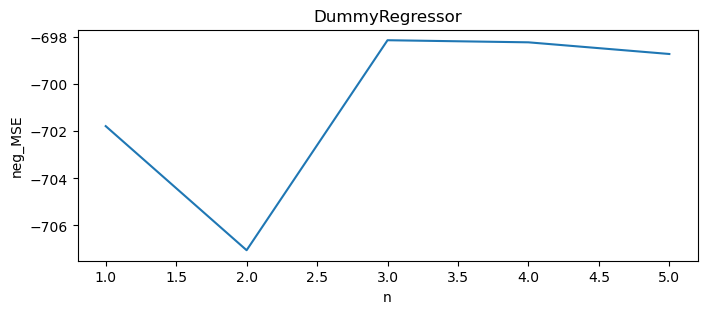

Score moyen sur 5 splits :  -700.78
------------------------------


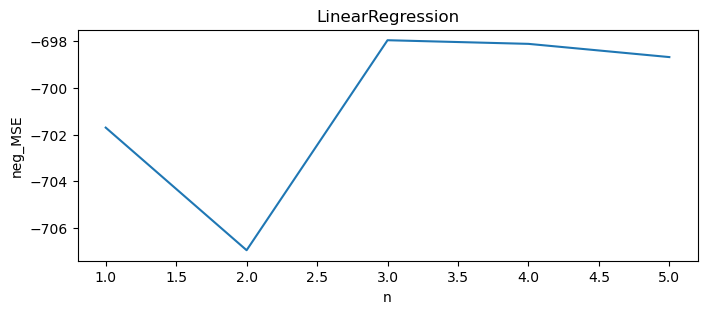

Score moyen sur 5 splits :  -700.68
------------------------------


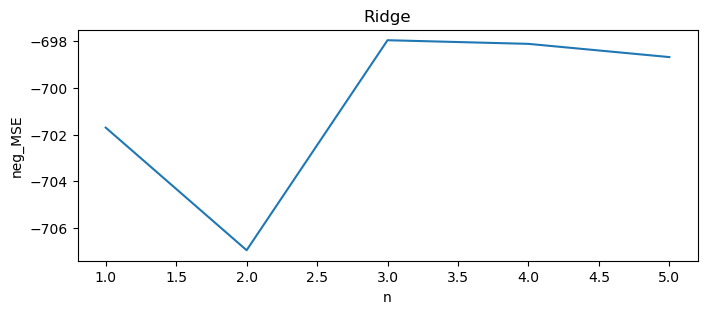

Score moyen sur 5 splits :  -700.68
------------------------------


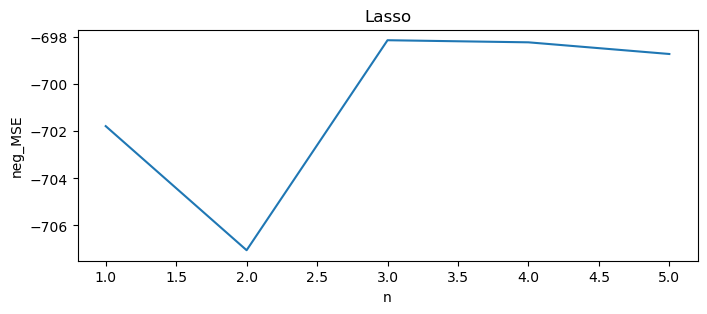

Score moyen sur 5 splits :  -700.78
------------------------------


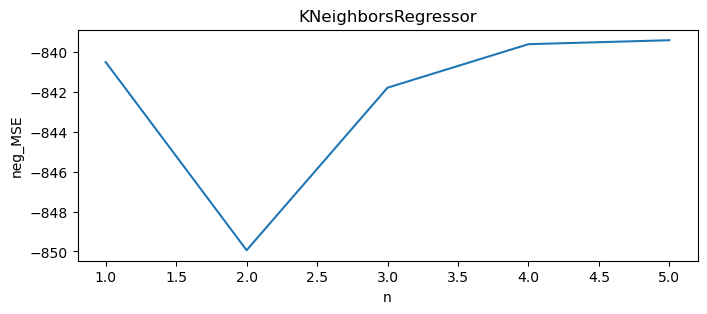

Score moyen sur 5 splits :  -842.26
------------------------------


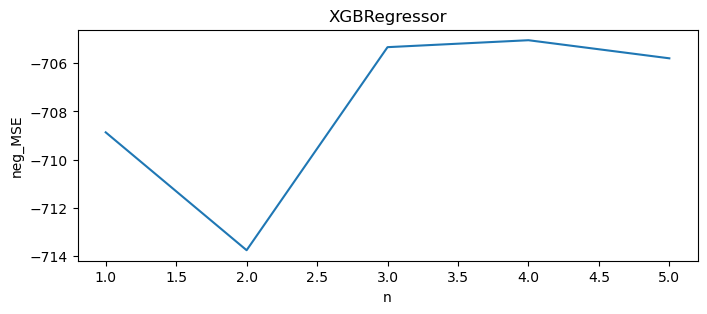

Score moyen sur 5 splits :  -707.76
------------------------------


In [10]:
model_trained, prediction, metric_df = evaluer_modele(models)

### 2.2 Mesure des resultats : RMSE, MSE, MAE, etc.

In [11]:
metric_df.drop("R2",axis=1, inplace=True)

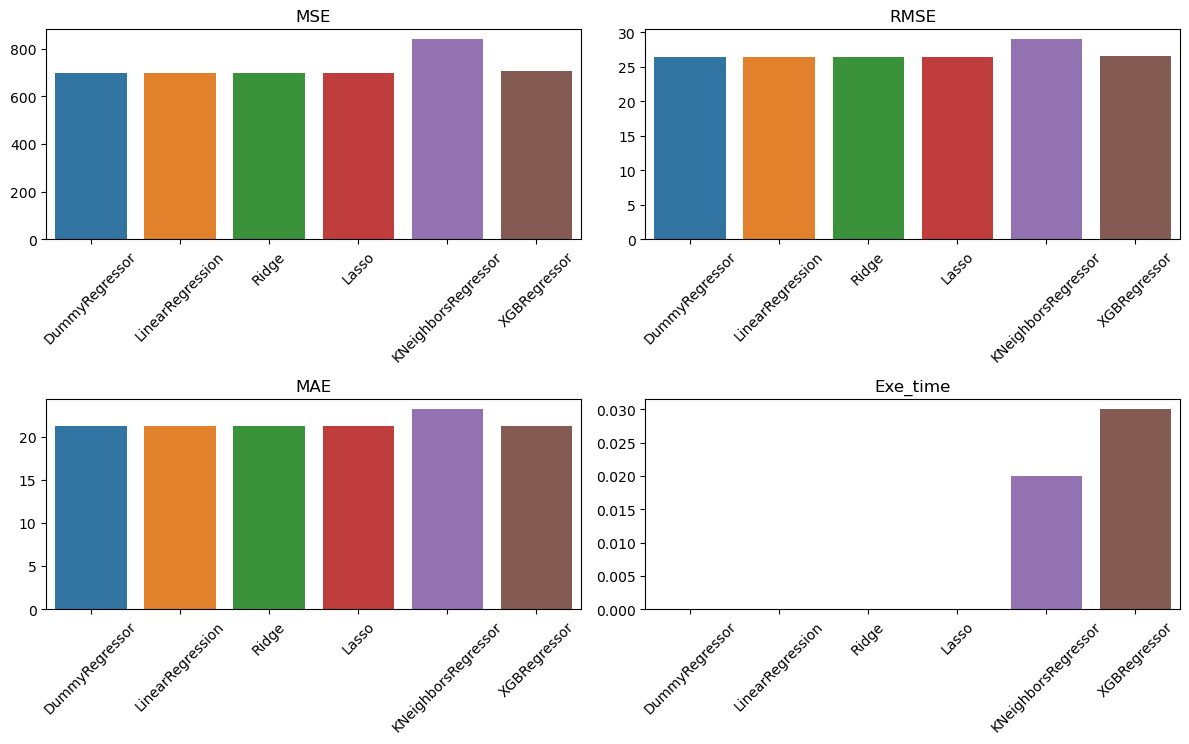

In [12]:
plt.figure(figsize=(12,10))
for i,col in enumerate(metric_df,1):
    plt.subplot(3,2,i)
    plt.title(f"{col}")
    ax = sns.barplot(x = metric_df.index, y = col , data = metric_df)
    lab = ax.get_xticklabels()
    ax.set_xticklabels(labels =lab,rotation=45)
    ax.set_ylabel(None)
    plt.tight_layout()
plt.show()

#### Observation : 
- Les résultats sont proches entre les modèles
- Cela pouvait être attendu pour les modèles linéaires car nous avions vu sur la partie EDA qu'il ne semble pas y avoir de relation linéaire entre la target et les features
- On observe une RMSE autour de 25 ce qui est assez prohe de 0, cela semble correct
- Une manière d'expliquer les résultats très proche du dummy est que nous avions vu dans le jeu de données que la target possède une distribution gaussienne unimodale. Prédire la moyenne est déjà un modèle assez **robuste**

Les résultats obtenus avec ces modèles en comparaison avec un modèle dummy peuvent indiquer :
- Soit que les features n’apportent pas d’information prédictive (faible corrélation avec y)
- Soit que nos modèles sont mal paramétrés / trop simple


### 2.3 graphique prediction Vs valeur réelle

In [159]:
def visualisation_pred_real(list_model,xsize=14,ysize=14):
    """
    Fonction qui récupère les prédictions d'un modèle et affiche un graphique en comparant avec les valeurs réelles
    les valeurs réelles sont sur l'axe des x et les valeurs prédites sont sur l'axe des y.
    La ligne rouge en pointillés représente une correspondance parfaite entre les valeurs réelles et prédites. 
    Dans un modèle parfait, tous les points se situeraient le long de cette ligne.
    return : scatterplot
    """
    
    plt.figure(figsize=(xsize,ysize))
    plt.suptitle('Scatter Plot des Valeurs Réelles vs. Prédites')

    for i, model in enumerate(list_model,1):
        plt.subplot(4,2,i)    
        y_pred = list_model[model].predict(X_test)
        plt.scatter(y_test, y_pred, color='blue', alpha=0.5) #scatterplot avec les vraies valeurs en x et les valeurs prédites en y
        plt.title(f"{model}")
        # Ajouter une ligne diagonale pour indiquer une correspondance parfaite entre les valeurs réelles et prédites
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
                 color='red', linestyle='--', label="Ideal (y = ŷ)")

        # Label et  titre
        plt.xlabel('Valeurs Réelles')
        plt.ylabel('Valeurs Prédites')
        plt.legend()
    plt.tight_layout()
    plt.show()

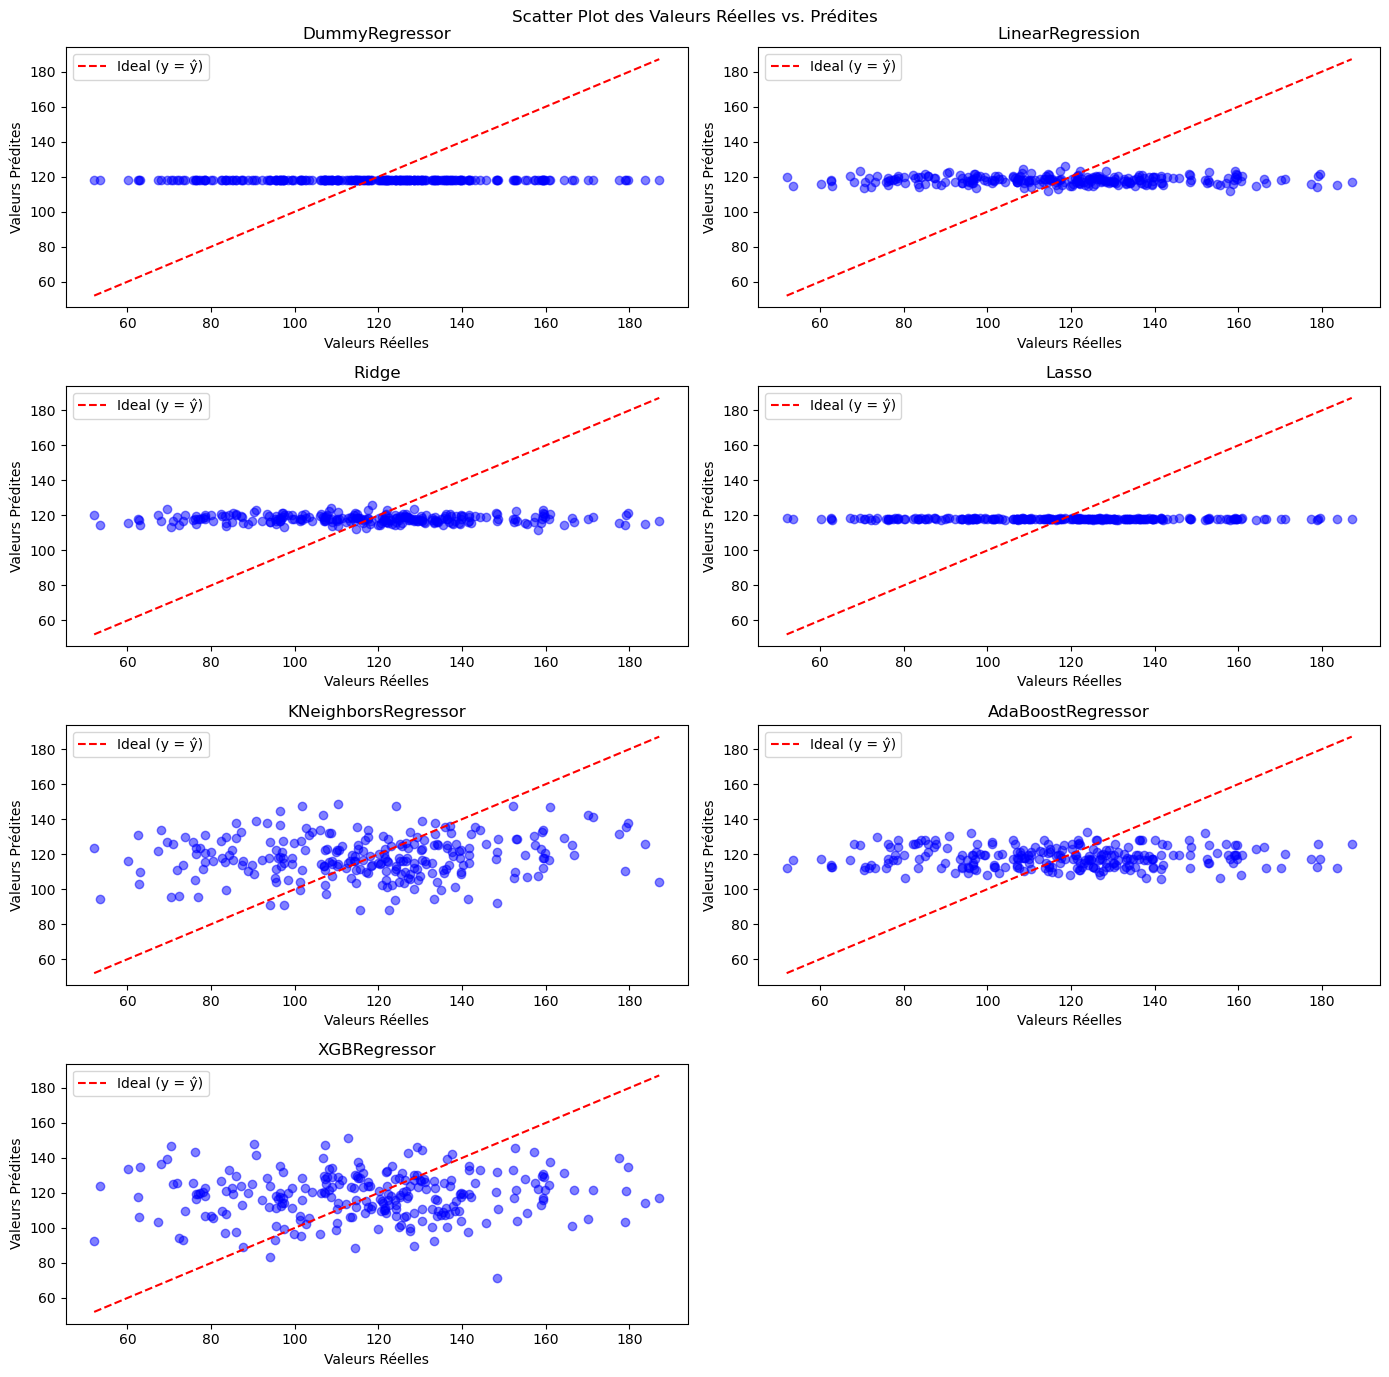

In [160]:
visualisation_pred_real(model_trained,xsize=14,ysize=14)

#### Observation : 
- Au vu des résultats obtenus, sans surprise les modèles linéaires ne font pas mieux qu'un modèle naïf
- Sur le graphique on peut apercevoir que le XGB donne des prédiction un peu plus étalé sur la diagonal, contrairement aux autres modèles, comme Lasso ou les prédictions sont complètement linéaire, calqué quasiment similaire au DummyRegressor

# 3. Explication modèle avec SHAP
Nous allons utiliser le modèle XGBoost et LinearRegression :
- Pour rappel, SHAP permet d’expliquer les prédictions des modèles de Machine Learning de manière compréhensible.
- Grâce à l’attribution d’une valeur à chaque caractéristique entrée, il montre comment et dans quelle mesure chaque caractéristique a contribué au résultat final de la prédiction
- utiliser cette technique permet de comprendre comment différentes caractéristiques affectent ensemble la prédiction du modèle.


In [41]:
model1 = model_trained['LinearRegression']

### Analyse de LinearRegression avec SHAP :

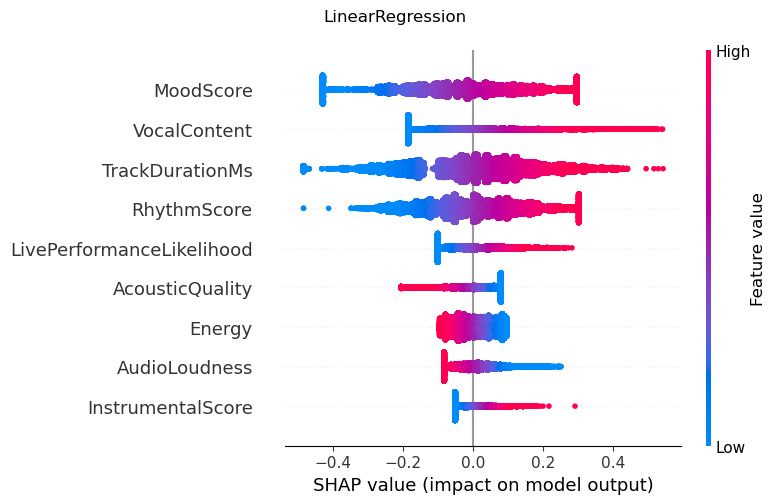

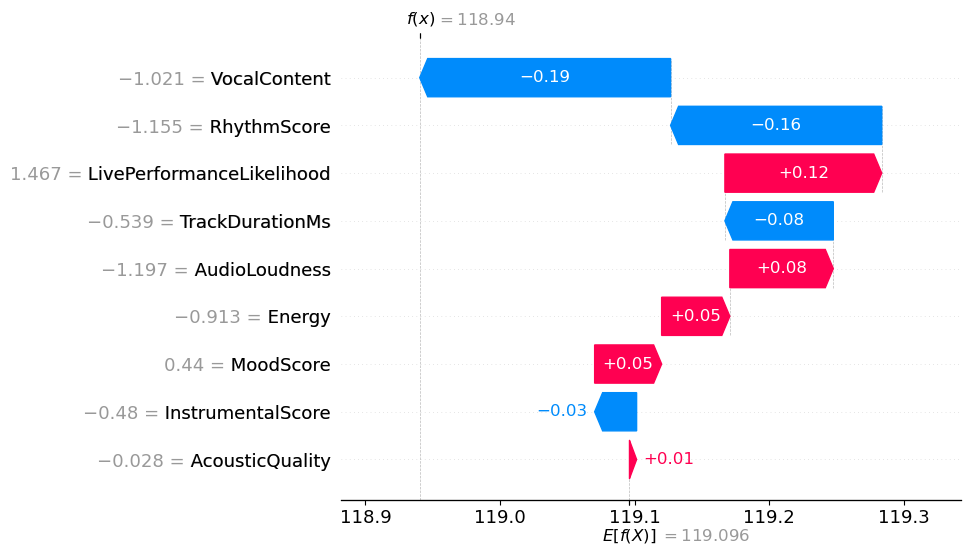

In [45]:
        # Création de l'explainer SHAP pour le modèle 
explainer = shap.Explainer(model1, X_train)
        #Calcul des valeurs SHAP sur les données de test
shap_values = explainer(X_test)
        #Titre graphique
plt.suptitle(model1.__class__.__name__)

        # Graphique global : importance moyenne des features + direction
shap.summary_plot(shap_values, X_test)
        
        # Graphique local : explication détaillée pour la première observation
shap.plots.waterfall(shap_values[0])

### Observation :
**Figure 1 : (global)** 
- Les features sont triées par importance globales sur les prédictions, on voit que MoodScore est celle qui a le plus d'impacte, InstrumentalScore le moins.
- L'axe des X est la valeur de SHAP (l'impact sur la prédiction; si positif cela augmente, si négatif diminue)
- La couleur c'est la valeur brute de la feature, en rouge c'est pour les grande valeur de la feature en question, en bleu pour les petites valeur

Prenons en exemple 2 features pour comprendre :
* **MoodScore** : Quand MoodScore à des valeurs élevées (point rouge) la prédiction est souvent haute (donc on prédit des valeurs de BeatsPerMinute élevée)
* **Energy** : A l'inverse, quand Energy est élevée on tire la prédiction vers le bas, donc plus la valeur de Energy est haute et plus la valeur de BeatsPerMinute est basse
    - Donc Cette feature fait que le modèle prédit une valeur de target plus faible que ce qu’il aurait prédit sans cette feature


**Figure 2 : (locale)**
- Ici on s'interesse sur une seule prédiction (individu) avec E[f(x)] = 118.96 qui est la prédiction **moyenne** du modèle
- Chaque barre montre combien cette feature **a ajouté ou enlevé à l baseline pour arriver à la prédiction finale f(x) = 118.94**

Par Exemple pour cet individu :

* VocalContent = -1.021 → contribue -0.19 → ça baisse la prédiction.
* RhythmScore = -1.155 → contribue -0.16.
* LivePerformanceLikelihood = 1.467 → contribue +0.12 (ça augmente la prédiction)

En additionnant toutes ces contributions, on part de 119.096 (baseline) et on arrive à 118.94 (prédiction finale).

### Analyse de XGBRegressor :

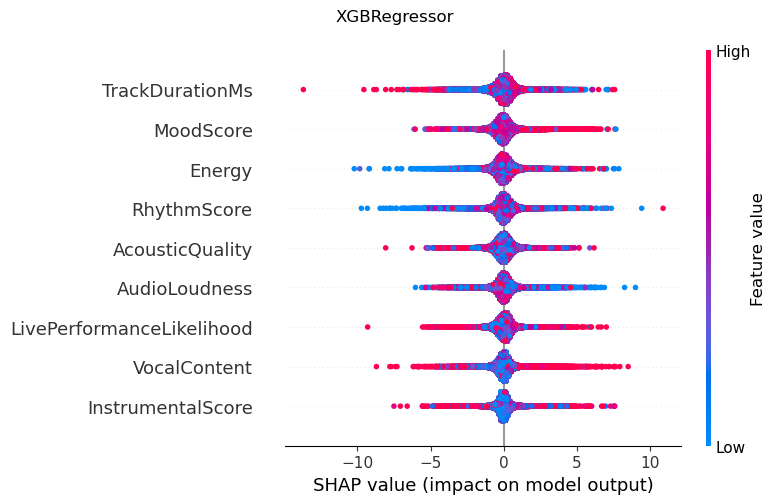

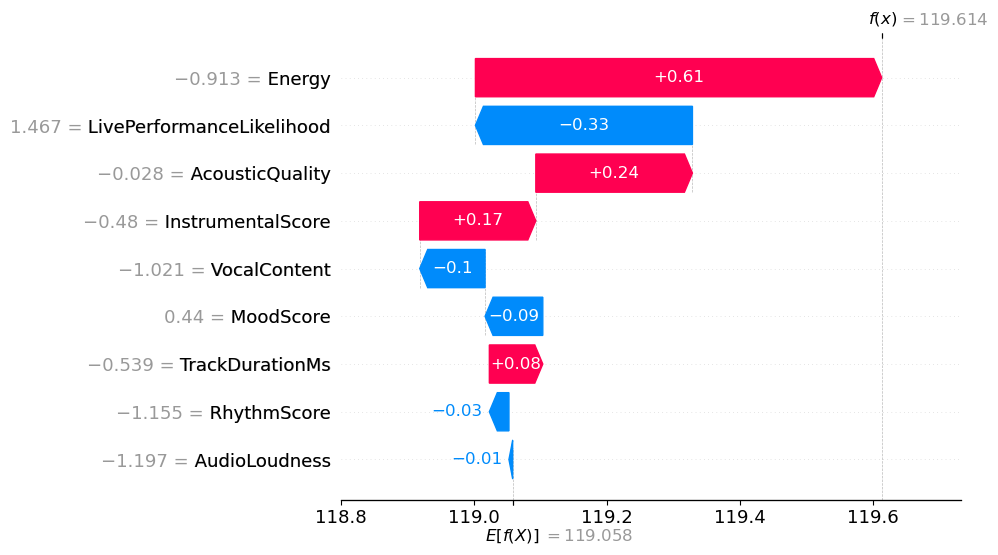

In [49]:
# SHAP 
explainer = shap.TreeExplainer(model2)
shap_values = explainer(X_test)

#Titre graph:
plt.suptitle(model2.__class__.__name__)

# Summary plot :
shap.summary_plot(shap_values, X_test)

# prédiction individuelle:
shap.plots.waterfall(shap_values[0])

### Observation : 
* Ici on observe un mélange plus complexe pour chaque feature
**Exemple** :
- **VocalContent** : des valeurs élevées sur cette feature peuvent à la fois faire tendre à baisser une prédiction vers le bas ou à la monter vers le haut

Il faut regarder la tendance dominante :

- Pour **TrackDurationMs**: 
    * la majorité des points rouges sont à gauche; tendance = “TrackDurationMs élevé : tire la prédiction vers le bas”. Mais comme il y a aussi des rouges à droite, ça veut dire : parfois un TrackDurationMs élevé peut aussi augmenter la prédiction (selon contexte)


- Les Chevauchements de points : 
    - C'est indicateur d’interactions importantes entre features; ca signifie que le modèle ne voit pas les features comme indépendantes, mais combine leurs effets

- Donc, le mélange rouge/bleu n’est pas une “erreur”, mais le signe que :
    - L’effet d’une variable dépend aussi d’autres variables
    - Le modèle est non linéaire et interactif

## Nouvelles prédiction sur le test : 
Nous allons utiliser une fonction qui prédit les données d'un modèle préentrainés sur un jeu de données que l'on passe en paramètre

In [34]:
def new_prediction(model, data):
    #Récupération des mêmes features que celles utilisés pour l'entrainement des modèles
    columns = model.feature_names_in_
    #Récupération de l'id du jeu de données
    id_data = data.index
    #Préparation du dataframe à tester :
    X = data[columns]
    #Récupération des prédictions
    numeric_prediction = model.predict(X)
    
    #Conversion des prédiction en données d'origine (textuelles et non numérique)
    # class_predicted = encoder_label.inverse_transform(numeric_prediction)   
    
    #Transformation des prédictions en dataframe avec l'id en index
    prediction_df = pd.DataFrame(numeric_prediction, columns = [y.name], index = id_data)
#     prediction_df = pd.DataFrame(class_predicted, columns = ["class"], index = id_data)
    return prediction_df


#### Preprocessing test : 

In [17]:
test[var_cont]  = std.transform(test[var_cont])

#### Entrainement sur le jeu de données complet :

In [36]:
best_model = XGBRegressor().fit(X,y)

##### Récupération des nouvelles prédiction de  données sur le test :

In [37]:
submission_pred = new_prediction(best_model,test)
#Récupération dans un fichier .csv pour soumission à kaggle
submission_pred.to_csv("XGBRegressor_1.csv")